In [1]:
# Importing necessary libraries

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import lsqr
from scipy.optimize import least_squares
import datetime as dt
from scipy.integrate import trapezoid, simpson
from scipy.optimize import curve_fit
from scipy import signal

We shall deal with the fake dataset in this notebook to properly understand the calibration process. First, load in the synthetic dataset.

In [2]:
rootdir = 'scizone1_nooffset/'

In [3]:
igrf_dat_dir = rootdir + 'elx_bt89_gei.txt'
att_dat_dir = rootdir + 'elx_att_gei.txt'
fgmc_dat_dir = rootdir + 'elx_fgs.txt'

Load in the IGRF fields/ attitude vector estimates in GEI coordinates, and the raw sensor data.

In [4]:
igrf_data = np.loadtxt(igrf_dat_dir, dtype=str)
att_data = np.loadtxt(att_dat_dir, dtype=str)
fgmc_data = np.loadtxt(fgmc_dat_dir, dtype=str)

In [5]:
# Obtain relative timestamps
times = list(fgmc_data[:,0])
times = [t.replace('/', ' ') for t in times]
data = pd.DataFrame(times, columns = ['Time (Full)'])
data['Time (Full)'] = pd.to_datetime(data['Time (Full)'])
data['Time (Full)'] = data['Time (Full)']-data['Time (Full)'][0]
data['ctime'] = data['Time (Full)'].dt.total_seconds()
data = data.drop('Time (Full)', axis=1)
ctime = np.array(data['ctime'])

In [6]:
# Unpack IGRF field and satellite attitude in GEI coordinates, and raw sensor data in FGM coordinates

B_IGRF_GEI_x = np.float_(igrf_data[:,1])
B_IGRF_GEI_y = np.float_(igrf_data[:,2])
B_IGRF_GEI_z = np.float_(igrf_data[:,3])

att_GEI_x = np.float_(att_data[:, 1])
att_GEI_y = np.float_(att_data[:, 2])
att_GEI_z = np.float_(att_data[:, 3])

B_raw_FGM_x = np.float_(fgmc_data[:,1])
B_raw_FGM_y = np.float_(fgmc_data[:,2])
B_raw_FGM_z = np.float_(fgmc_data[:,3])

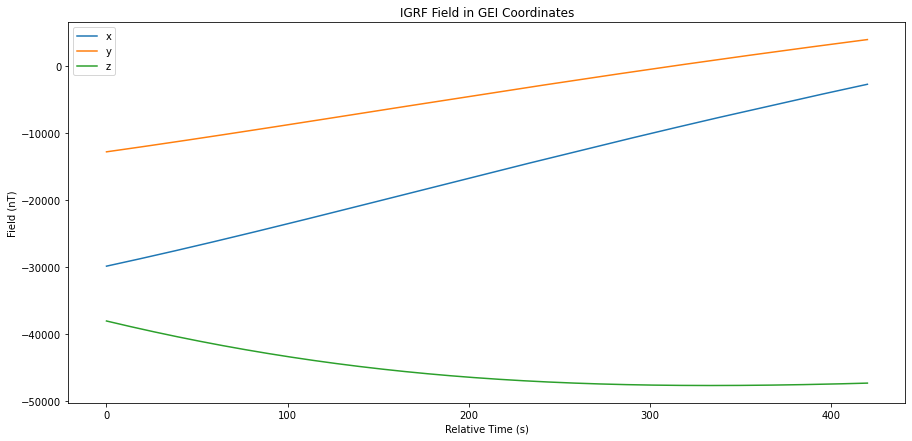

In [7]:
fig, ax = plt.subplots(1, figsize = (15, 7))

ax.plot(ctime, B_IGRF_GEI_x, label='x')
ax.plot(ctime, B_IGRF_GEI_y, label='y')
ax.plot(ctime, B_IGRF_GEI_z, label='z')

ax.set_title('IGRF Field in GEI Coordinates')
ax.set_xlabel('Relative Time (s)')
ax.set_ylabel('Field (nT)')
ax.legend()

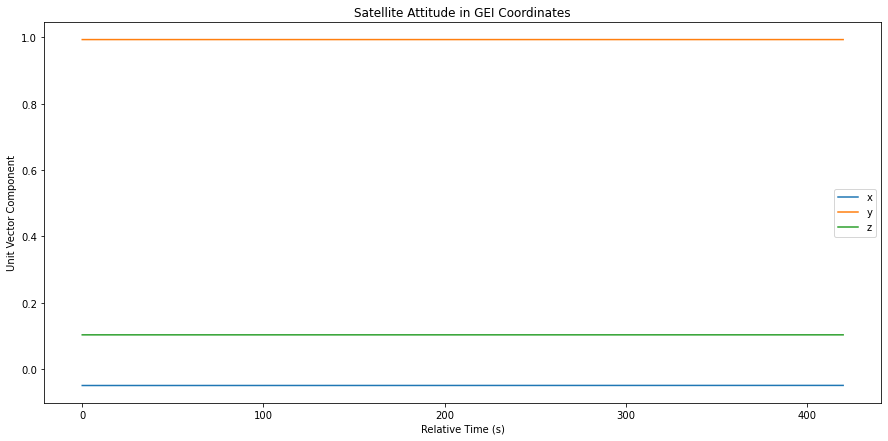

In [8]:
fig, ax = plt.subplots(1, figsize = (15, 7))

ax.plot(ctime, att_GEI_x, label='x')
ax.plot(ctime, att_GEI_y, label='y')
ax.plot(ctime, att_GEI_z, label='z')

ax.set_title('Satellite Attitude in GEI Coordinates')
ax.set_xlabel('Relative Time (s)')
ax.set_ylabel('Unit Vector Component')
ax.legend()

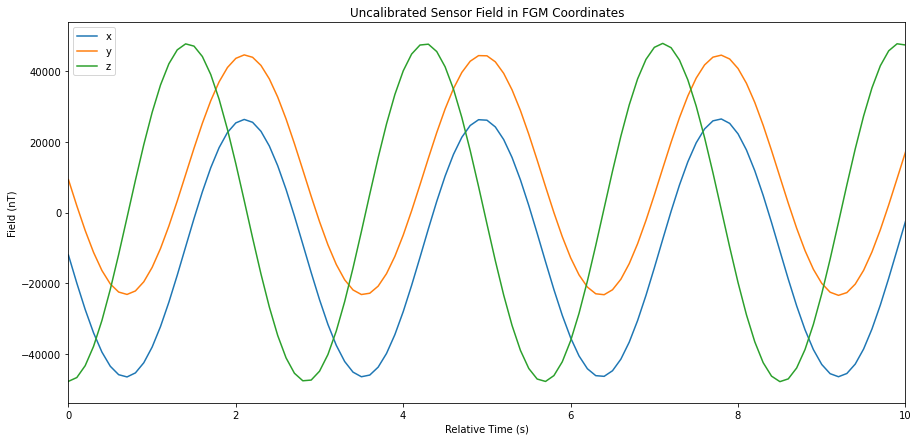

In [9]:
fig, ax = plt.subplots(1, figsize = (15, 7))

ax.plot(ctime, B_raw_FGM_x, label='x')
ax.plot(ctime, B_raw_FGM_y, label='y')
ax.plot(ctime, B_raw_FGM_z, label='z')

ax.set_title('Uncalibrated Sensor Field in FGM Coordinates')
ax.set_xlabel('Relative Time (s)')
ax.set_ylabel('Field (nT)')
ax.set_xlim(0, 10)
ax.legend()

We'll guess the spin-period of the spacecraft to be slightly off from the true value of 2.84s.

In [10]:
T_init = 2.84 + 1e-5

Let us compute the first zero-crossing time to get the zero-phase for rotation angles.

In [11]:
d_B_raw_FGM_z = np.gradient(B_raw_FGM_z)/np.gradient(ctime)

for j in range(len(ctime)-1):
    if(d_B_raw_FGM_z[j]*d_B_raw_FGM_z[j+1]<0 and d_B_raw_FGM_z[j]>0):
        y1 = d_B_raw_FGM_z[j]
        y2 = d_B_raw_FGM_z[j+1]
        x1 = ctime[j]
        x2 = ctime[j+1]
        t0_init = (y2*x1 - y1*x2)/(y2 - y1)
        break

phase_init = np.zeros(len(ctime))

idx = ((ctime-t0_init)>=-T_init/2) & ((ctime-t0_init)<=T_init/2)
phase_init[idx] = np.arcsin(d_B_raw_FGM_z[idx]/np.max(np.abs(d_B_raw_FGM_z[idx])))

for k in range(len(ctime)-1):
    if(phase_init[k]*phase_init[k+1]<0 and phase_init[k]>0):
        y1 = phase_init[k]
        y2 = phase_init[k+1]
        x1 = ctime[k]
        x2 = ctime[k+1]
        t0_init = (y2*x1 - y1*x2)/(y2 - y1)
        break

We can see how the IGRF field directions change in GEI coordinates.

In [12]:
B_hat_IGRF_GEI_x = B_IGRF_GEI_x/np.sqrt(B_IGRF_GEI_x**2 + B_IGRF_GEI_y**2 + B_IGRF_GEI_z**2)
B_hat_IGRF_GEI_y = B_IGRF_GEI_y/np.sqrt(B_IGRF_GEI_x**2 + B_IGRF_GEI_y**2 + B_IGRF_GEI_z**2)
B_hat_IGRF_GEI_z = B_IGRF_GEI_z/np.sqrt(B_IGRF_GEI_x**2 + B_IGRF_GEI_y**2 + B_IGRF_GEI_z**2)

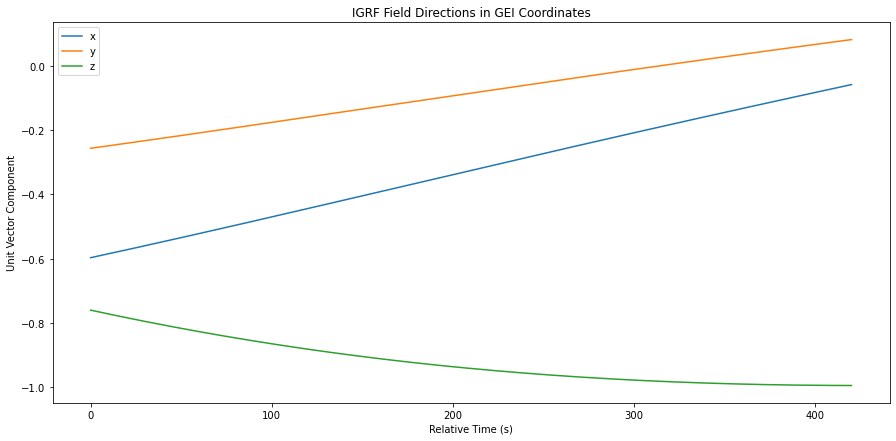

In [13]:
fig, ax = plt.subplots(1, figsize = (15, 7))

ax.plot(ctime, B_hat_IGRF_GEI_x, label='x')
ax.plot(ctime, B_hat_IGRF_GEI_y, label='y')
ax.plot(ctime, B_hat_IGRF_GEI_z, label='z')

ax.set_title('IGRF Field Directions in GEI Coordinates')
ax.set_xlabel('Relative Time (s)')
ax.set_ylabel('Unit Vector Component')

ax.legend()

We start from a perfect guess of the spacecraft attitude.

In [14]:
u_hat_init = np.array([np.mean(att_GEI_x), np.mean(att_GEI_y), np.mean(att_GEI_z)])
b_hat = np.array([B_hat_IGRF_GEI_x[0], B_hat_IGRF_GEI_y[0], B_hat_IGRF_GEI_z[0]])

In [15]:
u_hat_init

array([-0.04931144,  0.99342941,  0.10327815])

Next, we compute the attitude angles in spherical coordinates (GEI) of the correct attitude vector.

In [16]:
# Calculates the spherical angle representation of a unit vector v_hat

def calc_unit_vec_angles(v_hat):
    
    v_hat_x = v_hat[0]
    v_hat_y = v_hat[1]
    v_hat_z = v_hat[2]
    
    theta = np.arccos(v_hat_z)
    
    cos_phi = v_hat_x/np.sin(theta)
    sin_phi = v_hat_y/np.sin(theta)

    if(cos_phi>0 and sin_phi>0):
        phi = np.arcsin(sin_phi)

    elif(cos_phi<0 and sin_phi>0):
        phi = np.arccos(cos_phi)

    elif(cos_phi<0 and sin_phi<0):
        phi = 2*np.pi-np.arccos(cos_phi)

    else:
        phi = 2*np.pi+np.arcsin(sin_phi)
        
    return np.array([theta, phi])

In [17]:
att_angles_init = calc_unit_vec_angles(u_hat_init)

We perturb the attitude angles by a little bit, and then re-construct an imperfect guess for the attitude that we will use from this point on.

In [18]:
# Small angle deviations
att_angles_init[0] += 1e-7
att_angles_init[1] -= 1e-5

In [19]:
# Reconstruct the incorrect attitude vector using perturbed attitude angles
u_hat_init = np.array([np.sin(att_angles_init[0])*np.cos(att_angles_init[1]), 
      np.sin(att_angles_init[0])*np.sin(att_angles_init[1]), 
      np.cos(att_angles_init[0])])

In [20]:
u_hat_init

array([-0.0493015 ,  0.99342992,  0.10327805])

Next, we create the following matrix that transforms DSC to GEI coordinates -

$$L = \begin{pmatrix}
\frac{\hat{b} \times \hat{u}}{||\hat{b} \times \hat{u}||} & 
\frac{\hat{u} \times (\hat{b} \times \hat{u})}{||\hat{u} \times (\hat{b} \times \hat{u})||}& \hat{u}\\
\end{pmatrix}$$

Using the attitude angles $(\theta_u, \phi_u)$ in GEI coordinates and the IGRF field direction vector $\hat{b}$.

In [21]:
# Function for creating the transformation from DSC to GEI coordinates, using attitude angles and IGRF field dirn

def orth_mat_create(att_angles, b_hat):
    
    orth_mat = np.zeros((3, 3))

    # First construct the attitude vector using attitude angles
    u_hat = np.array([np.sin(att_angles[0])*np.cos(att_angles[1]), 
          np.sin(att_angles[0])*np.sin(att_angles[1]), 
          np.cos(att_angles[0])])
    
    # Then create the matrix
    orth_mat[:,0] = np.cross(b_hat, u_hat)
    orth_mat[:,1] = np.cross(u_hat, np.cross(b_hat, u_hat))
    orth_mat[:,2] = u_hat
    
    # Re-normalize each column vector
    orth_mat[:,0] /= np.linalg.norm(orth_mat[:,0])
    orth_mat[:,1] /= np.linalg.norm(orth_mat[:,1])
    orth_mat[:,2] /= np.linalg.norm(orth_mat[:,2])    
    
    return orth_mat

In [22]:
DSC_2_GEI_init = orth_mat_create(att_angles_init, b_hat)

In [23]:
DSC_2_GEI_init

array([[ 0.76494092, -0.64221083, -0.0493015 ],
       [ 0.10404414,  0.04766352,  0.99342992],
       [-0.63564157, -0.76504473,  0.10327805]])

In [24]:
GEI_2_DSC_init = np.linalg.inv(DSC_2_GEI_init)

Next, we take the IGRF fields from GEI to DSC and plot them

In [25]:
B_IGRF_DSC_x = GEI_2_DSC_init[0,0]*B_IGRF_GEI_x + GEI_2_DSC_init[0,1]*B_IGRF_GEI_y + GEI_2_DSC_init[0,2]*B_IGRF_GEI_z
B_IGRF_DSC_y = GEI_2_DSC_init[1,0]*B_IGRF_GEI_x + GEI_2_DSC_init[1,1]*B_IGRF_GEI_y + GEI_2_DSC_init[1,2]*B_IGRF_GEI_z
B_IGRF_DSC_z = GEI_2_DSC_init[2,0]*B_IGRF_GEI_x + GEI_2_DSC_init[2,1]*B_IGRF_GEI_y + GEI_2_DSC_init[2,2]*B_IGRF_GEI_z

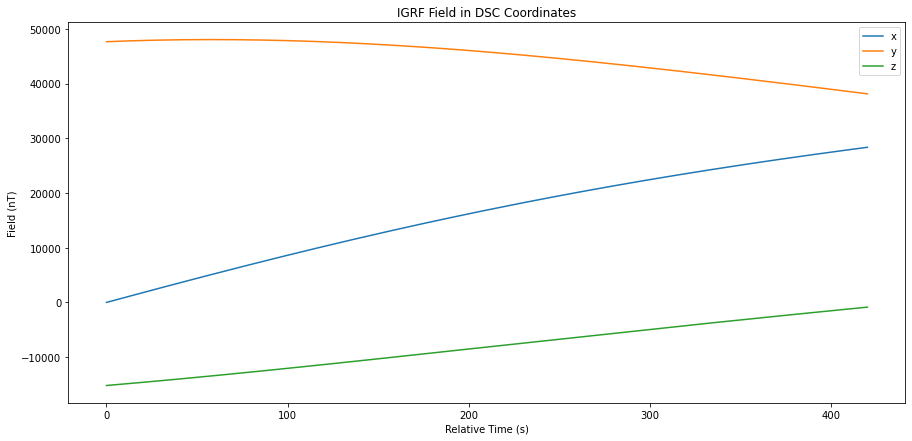

In [26]:
fig, ax = plt.subplots(1, figsize = (15, 7))

ax.plot(ctime, B_IGRF_DSC_x, label='x')
ax.plot(ctime, B_IGRF_DSC_y, label='y')
ax.plot(ctime, B_IGRF_DSC_z, label='z')

ax.set_title('IGRF Field in DSC Coordinates')
ax.set_xlabel('Relative Time (s)')
ax.set_ylabel('Field (nT)')
ax.legend()

Then, we respin the data from DSC coordinates into RSC coordinates

In [27]:
w_init = 2*np.pi/T_init

# Zero-phase for rotation based on first "zero-crossing" of raw sensor field along FGM z
phi0_init = (-w_init*t0_init)%(2*np.pi)

# Can use below guess instead for smaller error in zero-phase
#phi0_init = np.pi #+ .1

phi_init = w_init*ctime + phi0_init

In [28]:
B_IGRF_RSC_x = np.cos(phi_init)*B_IGRF_DSC_x + np.sin(phi_init)*B_IGRF_DSC_y
B_IGRF_RSC_y = -np.sin(phi_init)*B_IGRF_DSC_x + np.cos(phi_init)*B_IGRF_DSC_y
B_IGRF_RSC_z = B_IGRF_DSC_z

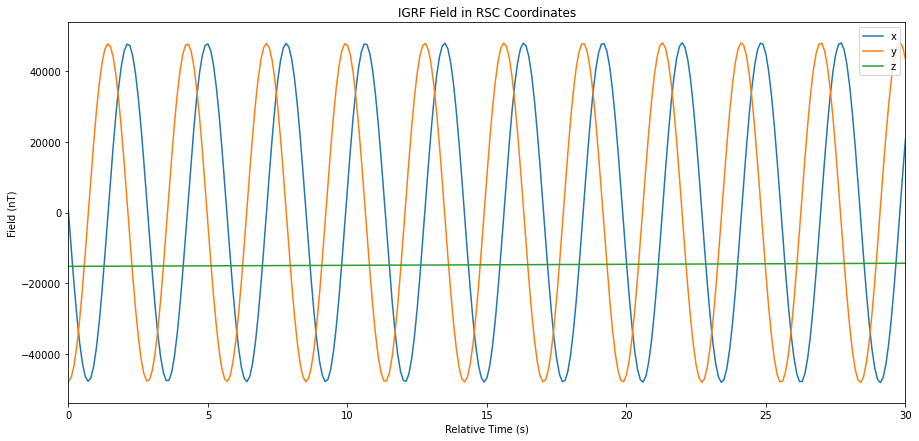

In [29]:
fig, ax = plt.subplots(1, figsize = (15, 7))

ax.plot(ctime, B_IGRF_RSC_x, label='x')
ax.plot(ctime, B_IGRF_RSC_y, label='y')
ax.plot(ctime, B_IGRF_RSC_z, label='z')

ax.set_title('IGRF Field in RSC Coordinates')
ax.set_xlabel('Relative Time (s)')
ax.set_ylabel('Field (nT)')
ax.set_xlim(0, 30)
ax.legend()

Finally, we move the IGRF field from RSC to FGM coordinates using the inverse of the transformation -

$$\Gamma = \begin{pmatrix}
\cos(f) & \sin(f) & 0\\
0 & 0 & 1\\
\sin(f) & -\cos(f) & 0
\end{pmatrix}$$

Which transforms FGM to RSC coordinates.

In [30]:
f = 44*np.pi/180

In [31]:
FGM_2_RSC = np.array([[np.cos(f),np.sin(f),0],[0,0,1],[np.sin(f),-np.cos(f),0]])

In [32]:
RSC_2_FGM = np.linalg.inv(FGM_2_RSC)

In [33]:
B_IGRF_FGM_x = RSC_2_FGM[0,0]*B_IGRF_RSC_x + RSC_2_FGM[0,1]*B_IGRF_RSC_y + RSC_2_FGM[0,2]*B_IGRF_RSC_z
B_IGRF_FGM_y = RSC_2_FGM[1,0]*B_IGRF_RSC_x + RSC_2_FGM[1,1]*B_IGRF_RSC_y + RSC_2_FGM[1,2]*B_IGRF_RSC_z
B_IGRF_FGM_z = RSC_2_FGM[2,0]*B_IGRF_RSC_x + RSC_2_FGM[2,1]*B_IGRF_RSC_y + RSC_2_FGM[2,2]*B_IGRF_RSC_z

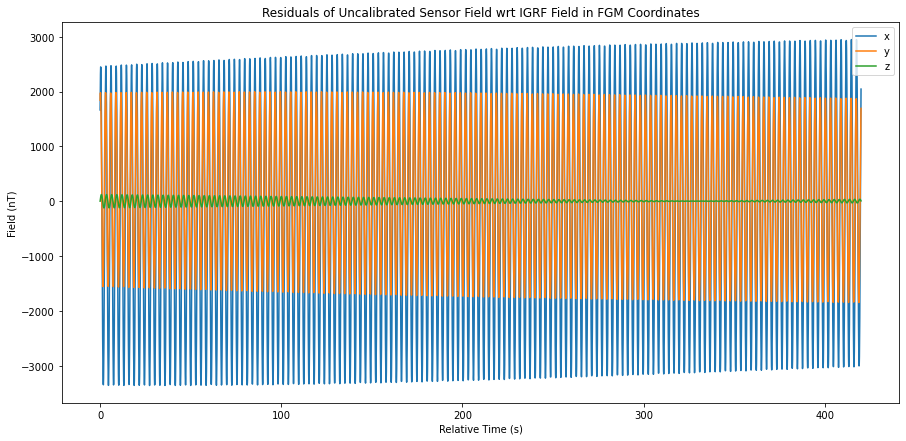

In [34]:
fig, ax = plt.subplots(1, figsize = (15, 7))

ax.plot(ctime, B_IGRF_FGM_x-B_raw_FGM_x, label='x')
ax.plot(ctime, B_IGRF_FGM_y-B_raw_FGM_y, label='y')
ax.plot(ctime, B_IGRF_FGM_z-B_raw_FGM_z, label='z')

ax.set_title('Residuals of Uncalibrated Sensor Field wrt IGRF Field in FGM Coordinates')
ax.set_xlabel('Relative Time (s)')
ax.set_ylabel('Field (nT)')
#ax.set_xlim(0, 10)
ax.legend()

Next, let us obtain the cal-params in the FGM coordinates (orthogonality matrix and offsets) by comparing the raw sensor data against IGRF fields.

In [35]:
n = len(ctime)

In [36]:
b_FGM_cal = np.concatenate((B_raw_FGM_x, B_raw_FGM_y, B_raw_FGM_z))

In [37]:
A_FGM_cal = np.zeros((3*n, 12))

A_FGM_cal[0:n,0] = B_IGRF_FGM_x
A_FGM_cal[0:n,1] = B_IGRF_FGM_y
A_FGM_cal[0:n,2] = B_IGRF_FGM_z
A_FGM_cal[0:n,3] = np.ones(n)
A_FGM_cal[n:2*n,4] = B_IGRF_FGM_x
A_FGM_cal[n:2*n,5] = B_IGRF_FGM_y
A_FGM_cal[n:2*n,6] = B_IGRF_FGM_z
A_FGM_cal[n:2*n,7] = np.ones(n)
A_FGM_cal[2*n:3*n,8] = B_IGRF_FGM_x
A_FGM_cal[2*n:3*n,9] = B_IGRF_FGM_y
A_FGM_cal[2*n:3*n,10] = B_IGRF_FGM_z
A_FGM_cal[2*n:3*n,11] = np.ones(n)

A_FGM_cal = csc_matrix(A_FGM_cal)

In [38]:
x_FGM_cal = lsqr(A_FGM_cal, b_FGM_cal, atol=1e-10, btol=1e-10)[0]

In [39]:
orth = np.array([[x_FGM_cal[0],x_FGM_cal[1],x_FGM_cal[2]], 
                 [x_FGM_cal[4], x_FGM_cal[5], x_FGM_cal[6]], 
                 [x_FGM_cal[8], x_FGM_cal[9], x_FGM_cal[10]]])

offsets = np.array([x_FGM_cal[3], x_FGM_cal[7], x_FGM_cal[11]])

In [40]:
#np.round(orth, 2)
orth

array([[1.00975448e+00, 4.97864050e-02, 4.57496884e-02],
       [1.98285968e-02, 9.99820654e-01, 3.53554671e-02],
       [5.64724428e-04, 7.52970567e-04, 1.00003750e+00]])

In [41]:
#np.round(offsets, 2)
offsets

array([ 2.96563629, -4.03198461, -5.1774709 ])

In [42]:
# This can reinstate perfect guesses for orth and offsets 
# Useful if you are trying to troubleshoot calibration for other parameters individually

#orth = np.array([[1.01, 0.05, 0.04], [0.02, 1.0, 0.03], [0.006, 0.006, 1.0]])
#offsets = np.array([100,100,100])

#orth = np.array([[1,0,0],[0,1,0],[0,0,1]])
#offsets = np.array([0,0,0])

Obtain the calibration matrix and apply it along with offsets to the raw sensor data.

In [43]:
calib = np.linalg.inv(orth)

In [44]:
B_cal_FGM_x = calib[0, 0]*(B_raw_FGM_x-offsets[0]) + calib[0, 1]*(B_raw_FGM_y-offsets[1]) + calib[0, 2]*(B_raw_FGM_z-offsets[2])
B_cal_FGM_y = calib[1, 0]*(B_raw_FGM_x-offsets[0]) + calib[1, 1]*(B_raw_FGM_y-offsets[1]) + calib[1, 2]*(B_raw_FGM_z-offsets[2])
B_cal_FGM_z = calib[2, 0]*(B_raw_FGM_x-offsets[0]) + calib[2, 1]*(B_raw_FGM_y-offsets[1]) + calib[2, 2]*(B_raw_FGM_z-offsets[2]) 

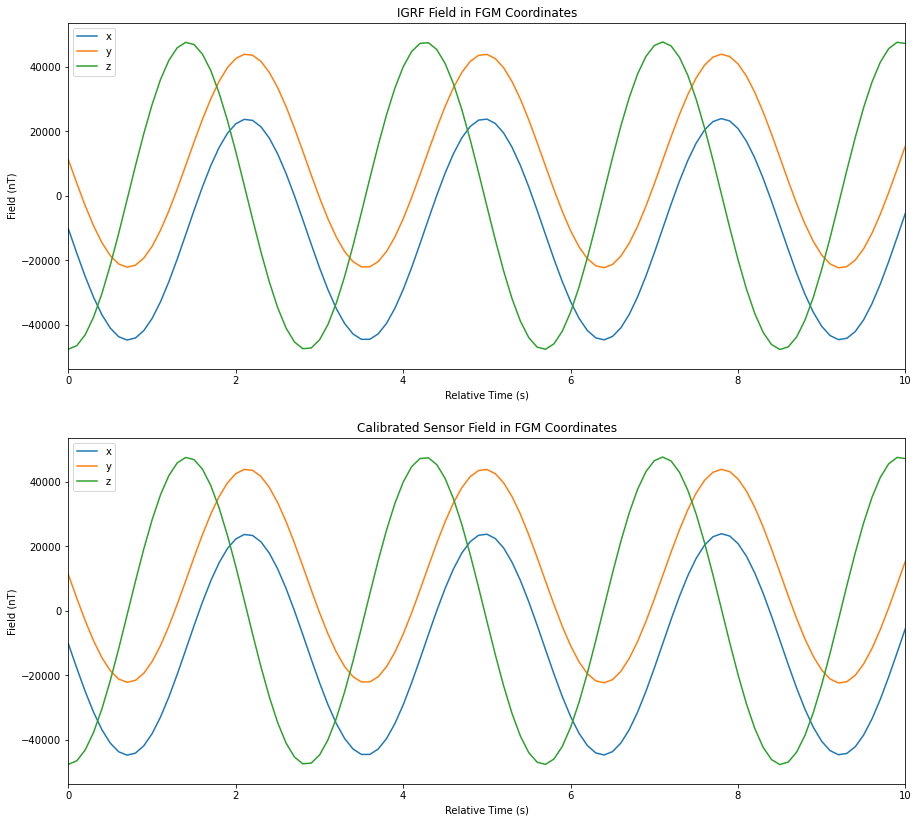

In [45]:
fig, axes = plt.subplots(2, 1, figsize = (15, 14))

axes[0].plot(ctime, B_IGRF_FGM_x, label='x')
axes[0].plot(ctime, B_IGRF_FGM_y, label='y')
axes[0].plot(ctime, B_IGRF_FGM_z, label='z')

axes[0].set_title('IGRF Field in FGM Coordinates')
axes[0].set_xlabel('Relative Time (s)')
axes[0].set_ylabel('Field (nT)')
axes[0].set_xlim(0, 10)
axes[0].legend()

axes[1].plot(ctime, B_cal_FGM_x, label='x')
axes[1].plot(ctime, B_cal_FGM_y, label='y')
axes[1].plot(ctime, B_cal_FGM_z, label='z')

axes[1].set_title('Calibrated Sensor Field in FGM Coordinates')
axes[1].set_xlabel('Relative Time (s)')
axes[1].set_ylabel('Field (nT)')
axes[1].set_xlim(0, 10)
axes[1].legend()

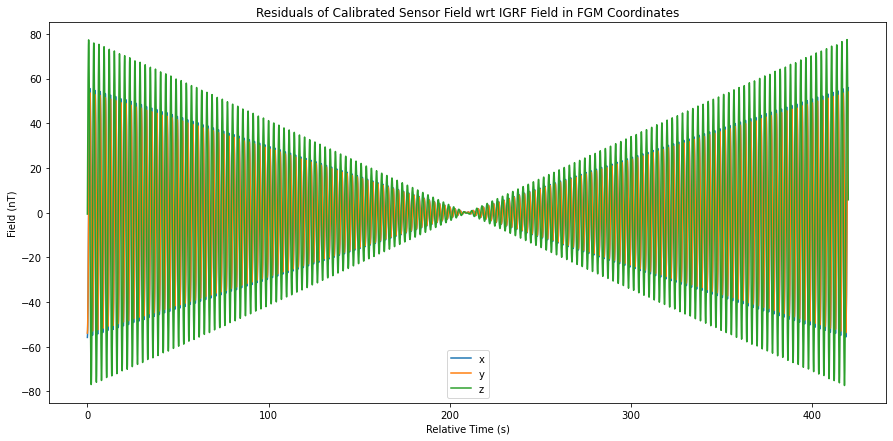

In [46]:
fig, ax = plt.subplots(1, figsize = (15, 7))

ax.plot(ctime, B_IGRF_FGM_x-B_cal_FGM_x, label='x')
ax.plot(ctime, B_IGRF_FGM_y-B_cal_FGM_y, label='y')
ax.plot(ctime, B_IGRF_FGM_z-B_cal_FGM_z, label='z')

ax.set_title('Residuals of Calibrated Sensor Field wrt IGRF Field in FGM Coordinates')
ax.set_xlabel('Relative Time (s)')
ax.set_ylabel('Field (nT)')
#ax.set_xlim(0, 10)
ax.legend()

Residuals go down a lot (from ~3000nT to ~80nT)! Let us do better and next correct the zero-phase and angular velocities. Begin with transforming the calibrated sensor field to RSC coordinates.

In [47]:
B_cal_RSC_x = FGM_2_RSC[0,0]*B_cal_FGM_x + FGM_2_RSC[0,1]*B_cal_FGM_y + FGM_2_RSC[0,2]*B_cal_FGM_z
B_cal_RSC_y = FGM_2_RSC[1,0]*B_cal_FGM_x + FGM_2_RSC[1,1]*B_cal_FGM_y + FGM_2_RSC[1,2]*B_cal_FGM_z
B_cal_RSC_z = FGM_2_RSC[2,0]*B_cal_FGM_x + FGM_2_RSC[2,1]*B_cal_FGM_y + FGM_2_RSC[2,2]*B_cal_FGM_z

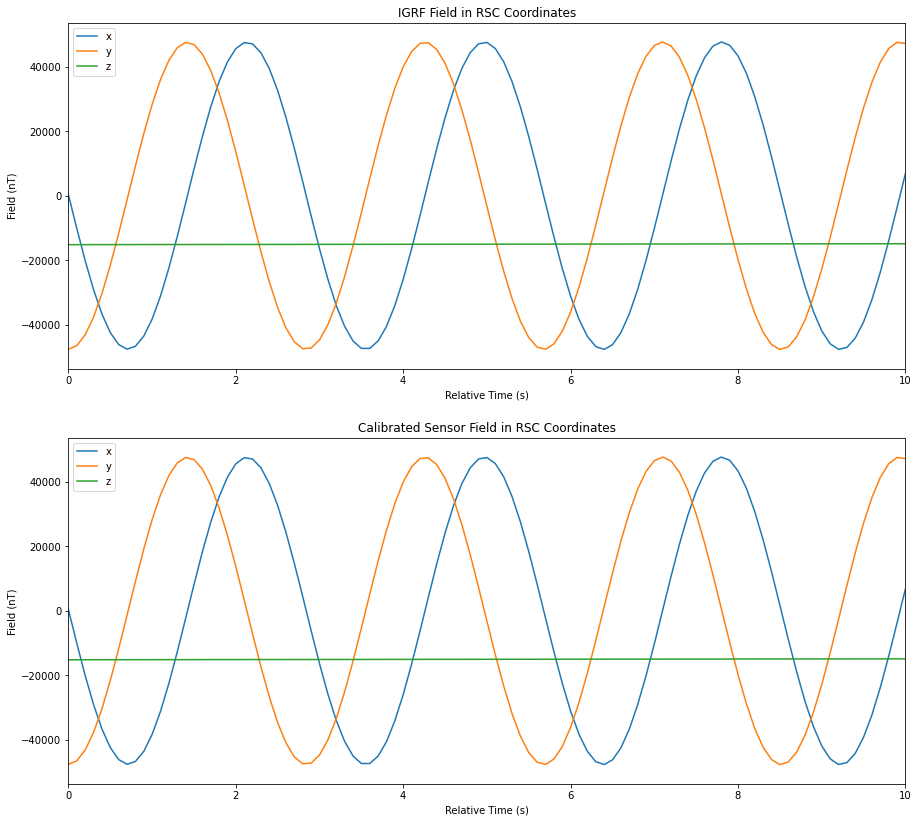

In [48]:
fig, axes = plt.subplots(2, 1, figsize = (15, 14))

axes[0].plot(ctime, B_IGRF_RSC_x, label='x')
axes[0].plot(ctime, B_IGRF_RSC_y, label='y')
axes[0].plot(ctime, B_IGRF_RSC_z, label='z')

axes[0].set_title('IGRF Field in RSC Coordinates')
axes[0].set_xlabel('Relative Time (s)')
axes[0].set_ylabel('Field (nT)')
axes[0].set_xlim(0, 10)
axes[0].legend()

axes[1].plot(ctime, B_cal_RSC_x, label='x')
axes[1].plot(ctime, B_cal_RSC_y, label='y')
axes[1].plot(ctime, B_cal_RSC_z, label='z')

axes[1].set_title('Calibrated Sensor Field in RSC Coordinates')
axes[1].set_xlabel('Relative Time (s)')
axes[1].set_ylabel('Field (nT)')
axes[1].set_xlim(0, 10)
axes[1].legend()

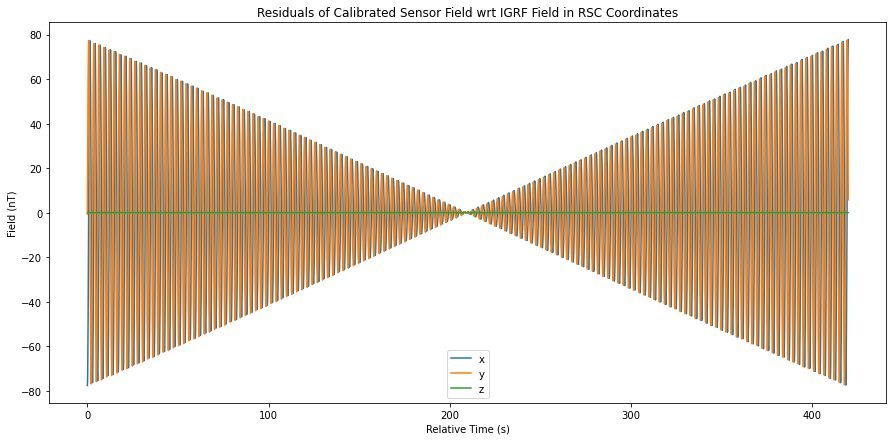

In [49]:
fig, ax = plt.subplots(1, figsize = (15, 7))

ax.plot(ctime, B_IGRF_RSC_x-B_cal_RSC_x, label='x')
ax.plot(ctime, B_IGRF_RSC_y-B_cal_RSC_y, label='y')
ax.plot(ctime, B_IGRF_RSC_z-B_cal_RSC_z, label='z')

ax.set_title('Residuals of Calibrated Sensor Field wrt IGRF Field in RSC Coordinates')
ax.set_xlabel('Relative Time (s)')
ax.set_ylabel('Field (nT)')
#ax.set_xlim(0, 10)
ax.legend()

In [50]:
phi0_init

3.1356701928312027

Next, we assume the angular velocity to be correct, but use normal equations to compute the correction to the zero-phase (check derivation separately).

In [51]:
# Normal equation for correcting zero-phase of rotation angles

b_phi0_cal = np.concatenate((B_cal_RSC_x, B_cal_RSC_y))

A_phi0_cal = np.zeros((2*n, 2))

A_phi0_cal[0:n,0] = np.cos(w_init*ctime)*B_IGRF_DSC_x + np.sin(w_init*ctime)*B_IGRF_DSC_y
A_phi0_cal[0:n,1] = np.cos(w_init*ctime)*B_IGRF_DSC_y - np.sin(w_init*ctime)*B_IGRF_DSC_x
A_phi0_cal[n:2*n,0] = np.cos(w_init*ctime)*B_IGRF_DSC_y - np.sin(w_init*ctime)*B_IGRF_DSC_x
A_phi0_cal[n:2*n,1] = -np.cos(w_init*ctime)*B_IGRF_DSC_x + np.sin(w_init*ctime)*B_IGRF_DSC_y

A_phi0_cal = csc_matrix(A_phi0_cal)

In [52]:
x_phi0_cal = lsqr(A_phi0_cal, b_phi0_cal, atol=1e-10, btol=1e-10)[0]

In [53]:
# Renormalize to avoid inversion errors ahead
cos_phi0_final = x_phi0_cal[0]/np.sqrt(x_phi0_cal[0]**2 + x_phi0_cal[1]**2)
sin_phi0_final = x_phi0_cal[1]/np.sqrt(x_phi0_cal[0]**2 + x_phi0_cal[1]**2)

In [54]:
# Isolate phi0 given cos_phi0 and sin_phi0
if(cos_phi0_final>0 and sin_phi0_final>0):
    phi0_final = np.arcsin(sin_phi0_final)
    
elif(cos_phi0_final<0 and sin_phi0_final>0):
    phi0_final = np.arccos(cos_phi0_final)
    
elif(cos_phi0_final<0 and sin_phi0_final<0):
    phi0_final = 2*np.pi-np.arccos(cos_phi0_final)
    
else:
    phi0_final = 2*np.pi+np.arcsin(sin_phi0_final)

In [55]:
# We moved closer to the true value!
phi0_init, phi0_final

(3.1356701928312027, 3.1408106872760206)

In [56]:
# Again, this can be used for reinstating the correct value for theta0, useful when troubleshooting
#theta0_final = theta0_init

Re-generate the model field using the improved value of zero-phase $\phi_0$.

In [57]:
phi_re = w_init*ctime + phi0_final

In [58]:
B_IGRF_RSC_x_re = np.cos(phi_re)*B_IGRF_DSC_x + np.sin(phi_re)*B_IGRF_DSC_y
B_IGRF_RSC_y_re = -np.sin(phi_re)*B_IGRF_DSC_x + np.cos(phi_re)*B_IGRF_DSC_y
B_IGRF_RSC_z_re = B_IGRF_DSC_z

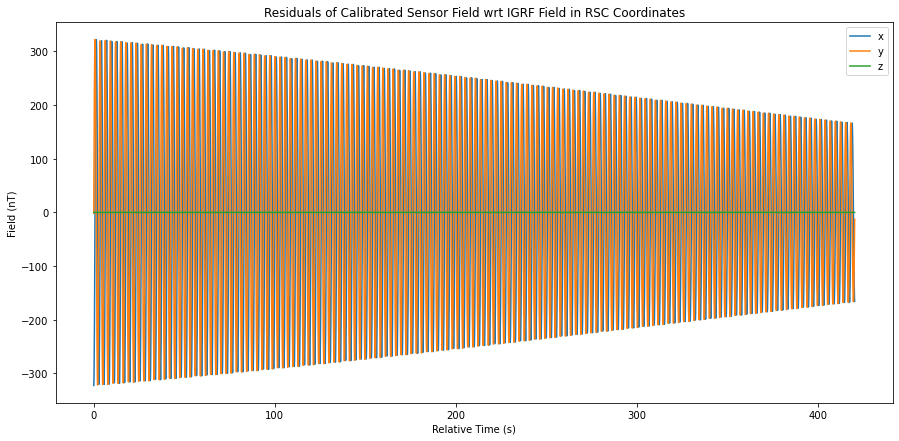

In [59]:
fig, ax = plt.subplots(1, figsize = (15, 7))

ax.plot(ctime, B_IGRF_RSC_x_re-B_cal_RSC_x, label='x')
ax.plot(ctime, B_IGRF_RSC_y_re-B_cal_RSC_y, label='y')
ax.plot(ctime, B_IGRF_RSC_z_re-B_cal_RSC_z, label='z')

ax.set_title('Residuals of Calibrated Sensor Field wrt IGRF Field in RSC Coordinates')
ax.set_xlabel('Relative Time (s)')
ax.set_ylabel('Field (nT)')
#ax.set_xlim(0, 10)
ax.legend()

The residuals increased because we need to use our refined guess of the zero-phase to recalibrate the raw sensor data in FGM coordinates once again.

In [60]:
B_IGRF_FGM_x_re = RSC_2_FGM[0,0]*B_IGRF_RSC_x_re + RSC_2_FGM[0,1]*B_IGRF_RSC_y_re + RSC_2_FGM[0,2]*B_IGRF_RSC_z_re
B_IGRF_FGM_y_re = RSC_2_FGM[1,0]*B_IGRF_RSC_x_re + RSC_2_FGM[1,1]*B_IGRF_RSC_y_re + RSC_2_FGM[1,2]*B_IGRF_RSC_z_re
B_IGRF_FGM_z_re = RSC_2_FGM[2,0]*B_IGRF_RSC_x_re + RSC_2_FGM[2,1]*B_IGRF_RSC_y_re + RSC_2_FGM[2,2]*B_IGRF_RSC_z_re

In [61]:
A_FGM_cal = np.zeros((3*n, 12))

A_FGM_cal[0:n,0] = B_IGRF_FGM_x_re
A_FGM_cal[0:n,1] = B_IGRF_FGM_y_re
A_FGM_cal[0:n,2] = B_IGRF_FGM_z_re
A_FGM_cal[0:n,3] = np.ones(n)
A_FGM_cal[n:2*n,4] = B_IGRF_FGM_x_re
A_FGM_cal[n:2*n,5] = B_IGRF_FGM_y_re
A_FGM_cal[n:2*n,6] = B_IGRF_FGM_z_re
A_FGM_cal[n:2*n,7] = np.ones(n)
A_FGM_cal[2*n:3*n,8] = B_IGRF_FGM_x_re
A_FGM_cal[2*n:3*n,9] = B_IGRF_FGM_y_re
A_FGM_cal[2*n:3*n,10] = B_IGRF_FGM_z_re
A_FGM_cal[2*n:3*n,11] = np.ones(n)

A_FGM_cal = csc_matrix(A_FGM_cal)

In [62]:
x_FGM_cal = lsqr(A_FGM_cal, b_FGM_cal, atol=1e-10, btol=1e-10)[0]

In [63]:
orth = np.array([[x_FGM_cal[0],x_FGM_cal[1],x_FGM_cal[2]], 
                 [x_FGM_cal[4], x_FGM_cal[5], x_FGM_cal[6]], 
                 [x_FGM_cal[8], x_FGM_cal[9], x_FGM_cal[10]]])

offsets = np.array([x_FGM_cal[3], x_FGM_cal[7], x_FGM_cal[11]])

In [64]:
orth

array([[1.00991641, 0.04994279, 0.04183749],
       [0.0199526 , 0.9999404 , 0.03171145],
       [0.0042626 , 0.00432397, 1.00001951]])

In [65]:
offsets

array([ 2.96563629, -4.03198461, -5.1774709 ])

In [66]:
#orth = np.array([[1.01, 0.05, 0.04], [0.02, 1.0, 0.03], [0.006, 0.006, 1.0]])
#offsets = np.array([100,100,100])

#orth = np.array([[1,0,0],[0,1,0],[0,0,1]])
#offsets = np.array([0,0,0])

In [67]:
calib = np.linalg.inv(orth)

In [68]:
B_cal_FGM_x = calib[0, 0]*(B_raw_FGM_x-offsets[0]) + calib[0, 1]*(B_raw_FGM_y-offsets[1]) + calib[0, 2]*(B_raw_FGM_z-offsets[2])
B_cal_FGM_y = calib[1, 0]*(B_raw_FGM_x-offsets[0]) + calib[1, 1]*(B_raw_FGM_y-offsets[1]) + calib[1, 2]*(B_raw_FGM_z-offsets[2])
B_cal_FGM_z = calib[2, 0]*(B_raw_FGM_x-offsets[0]) + calib[2, 1]*(B_raw_FGM_y-offsets[1]) + calib[2, 2]*(B_raw_FGM_z-offsets[2]) 

In [69]:
B_cal_RSC_x = FGM_2_RSC[0,0]*B_cal_FGM_x + FGM_2_RSC[0,1]*B_cal_FGM_y + FGM_2_RSC[0,2]*B_cal_FGM_z
B_cal_RSC_y = FGM_2_RSC[1,0]*B_cal_FGM_x + FGM_2_RSC[1,1]*B_cal_FGM_y + FGM_2_RSC[1,2]*B_cal_FGM_z
B_cal_RSC_z = FGM_2_RSC[2,0]*B_cal_FGM_x + FGM_2_RSC[2,1]*B_cal_FGM_y + FGM_2_RSC[2,2]*B_cal_FGM_z

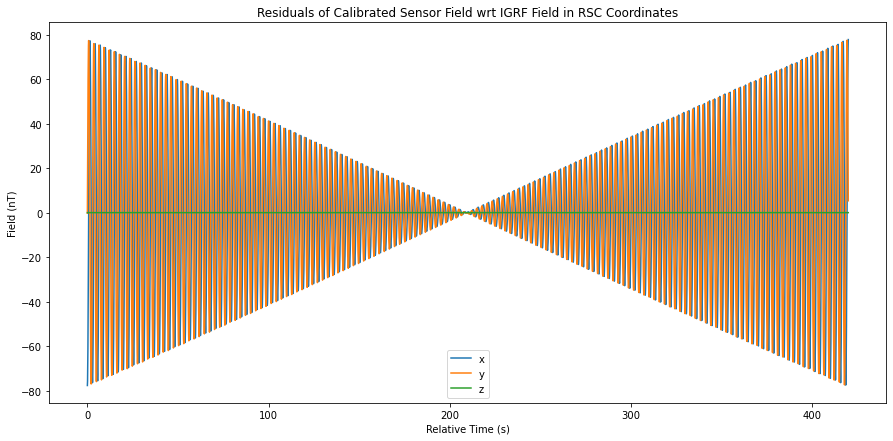

In [70]:
fig, ax = plt.subplots(1, figsize = (15, 7))

ax.plot(ctime, B_IGRF_RSC_x_re-B_cal_RSC_x, label='x')
ax.plot(ctime, B_IGRF_RSC_y_re-B_cal_RSC_y, label='y')
ax.plot(ctime, B_IGRF_RSC_z_re-B_cal_RSC_z, label='z')

ax.set_title('Residuals of Calibrated Sensor Field wrt IGRF Field in RSC Coordinates')
ax.set_xlabel('Relative Time (s)')
ax.set_ylabel('Field (nT)')
#ax.set_xlim(0, 10)
ax.legend()

The residuals went back to ~80nT, which means that having the correct zero-phase is necessary, but not sufficient to have the best calibration overall. Next, we correct for $\Delta \omega$. There is again a normal equation involved here, obtained by a linear approximation involving an assumption $\Delta \omega$ being small, but it is best to check the derivation separately. We just derive the value of $\Delta \omega$ by using the relevant normal equation.

In [71]:
Y_x = B_cal_RSC_x-B_IGRF_RSC_x_re
Y_y = B_cal_RSC_y-B_IGRF_RSC_y_re
Y_z = B_cal_RSC_z-B_IGRF_RSC_z_re

Y = np.concatenate((Y_x, Y_y, Y_z))

In [72]:
X_x = ctime*(-np.sin(phi_re)*B_IGRF_DSC_x + np.cos(phi_re)*B_IGRF_DSC_y)
X_y = ctime*(-np.cos(phi_re)*B_IGRF_DSC_x - np.sin(phi_re)*B_IGRF_DSC_y)
X_z = ctime*0

X = np.concatenate((X_x, X_y, X_z))

In [73]:
# Normal equation for correcting w
delta_w = np.sum(X*Y)/np.sum(X**2)

In [74]:
delta_w

1.9386831780395322e-06

In [75]:
w_final = w_init + delta_w

In [76]:
# We move closer to the true value here too!
T_init, 2*np.pi/w_final

(2.84001, 2.840007511335622)

See how we get closer to the true period! Let's regenerate the model field once again using the correct $\omega$.

In [77]:
phi_final = w_final*ctime + phi0_final

In [78]:
B_IGRF_RSC_x_final = np.cos(phi_final)*B_IGRF_DSC_x + np.sin(phi_final)*B_IGRF_DSC_y
B_IGRF_RSC_y_final = -np.sin(phi_final)*B_IGRF_DSC_x + np.cos(phi_final)*B_IGRF_DSC_y
B_IGRF_RSC_z_final = B_IGRF_DSC_z

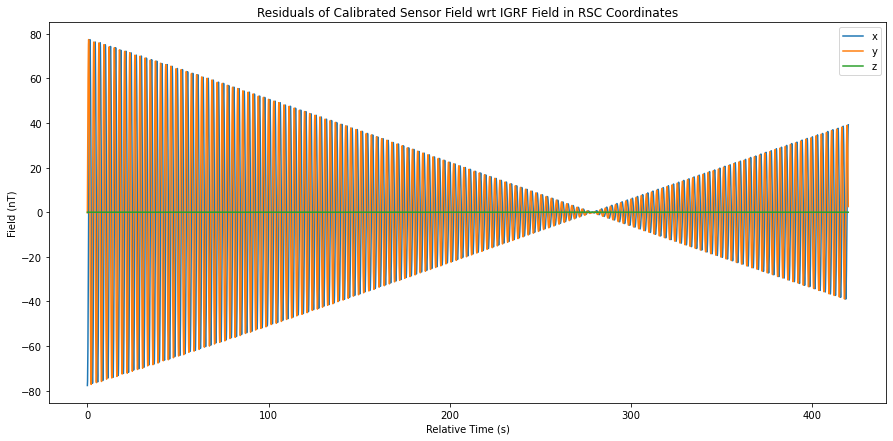

In [79]:
fig, ax = plt.subplots(1, figsize = (15, 7))

ax.plot(ctime, B_IGRF_RSC_x_final-B_cal_RSC_x, label='x')
ax.plot(ctime, B_IGRF_RSC_y_final-B_cal_RSC_y, label='y')
ax.plot(ctime, B_IGRF_RSC_z_final-B_cal_RSC_z, label='z')

ax.set_title('Residuals of Calibrated Sensor Field wrt IGRF Field in RSC Coordinates')
ax.set_xlabel('Relative Time (s)')
ax.set_ylabel('Field (nT)')
#ax.set_xlim(0, 10)
ax.legend()

Again, the residuals did not go down yet because we need to use the correct $\omega$ and zero-phase to recalibrate the raw sensor data, so let us do that.

In [80]:
B_IGRF_FGM_x_final = RSC_2_FGM[0,0]*B_IGRF_RSC_x_final + RSC_2_FGM[0,1]*B_IGRF_RSC_y_final + RSC_2_FGM[0,2]*B_IGRF_RSC_z_final
B_IGRF_FGM_y_final = RSC_2_FGM[1,0]*B_IGRF_RSC_x_final + RSC_2_FGM[1,1]*B_IGRF_RSC_y_final + RSC_2_FGM[1,2]*B_IGRF_RSC_z_final
B_IGRF_FGM_z_final = RSC_2_FGM[2,0]*B_IGRF_RSC_x_final + RSC_2_FGM[2,1]*B_IGRF_RSC_y_final + RSC_2_FGM[2,2]*B_IGRF_RSC_z_final

In [81]:
A_FGM_cal = np.zeros((3*n, 12))

A_FGM_cal[0:n,0] = B_IGRF_FGM_x_final
A_FGM_cal[0:n,1] = B_IGRF_FGM_y_final
A_FGM_cal[0:n,2] = B_IGRF_FGM_z_final
A_FGM_cal[0:n,3] = np.ones(n)
A_FGM_cal[n:2*n,4] = B_IGRF_FGM_x_final
A_FGM_cal[n:2*n,5] = B_IGRF_FGM_y_final
A_FGM_cal[n:2*n,6] = B_IGRF_FGM_z_final
A_FGM_cal[n:2*n,7] = np.ones(n)
A_FGM_cal[2*n:3*n,8] = B_IGRF_FGM_x_final
A_FGM_cal[2*n:3*n,9] = B_IGRF_FGM_y_final
A_FGM_cal[2*n:3*n,10] = B_IGRF_FGM_z_final
A_FGM_cal[2*n:3*n,11] = np.ones(n)

A_FGM_cal = csc_matrix(A_FGM_cal)

In [82]:
x_FGM_cal = lsqr(A_FGM_cal, b_FGM_cal, atol=1e-10, btol=1e-10)[0]

In [83]:
orth = np.array([[x_FGM_cal[0],x_FGM_cal[1],x_FGM_cal[2]], 
                 [x_FGM_cal[4], x_FGM_cal[5], x_FGM_cal[6]], 
                 [x_FGM_cal[8], x_FGM_cal[9], x_FGM_cal[10]]])

offsets = np.array([x_FGM_cal[3], x_FGM_cal[7], x_FGM_cal[11]])

In [84]:
orth

array([[1.00992961, 0.04995415, 0.04152855],
       [0.01996276, 0.99994894, 0.03142369],
       [0.00455482, 0.00460573, 1.00001674]])

In [85]:
offsets

array([ 2.97425455, -4.02427717, -5.13334558])

In [86]:
#orth = np.array([[1.01, 0.05, 0.04], [0.02, 1.0, 0.03], [0.006, 0.006, 1.0]])
#offsets = np.array([100,100,100])

#orth = np.array([[1,0,0],[0,1,0],[0,0,1]])
#offsets = np.array([0,0,0])

In [87]:
calib = np.linalg.inv(orth)

In [88]:
B_cal_FGM_x = calib[0, 0]*(B_raw_FGM_x-offsets[0]) + calib[0, 1]*(B_raw_FGM_y-offsets[1]) + calib[0, 2]*(B_raw_FGM_z-offsets[2])
B_cal_FGM_y = calib[1, 0]*(B_raw_FGM_x-offsets[0]) + calib[1, 1]*(B_raw_FGM_y-offsets[1]) + calib[1, 2]*(B_raw_FGM_z-offsets[2])
B_cal_FGM_z = calib[2, 0]*(B_raw_FGM_x-offsets[0]) + calib[2, 1]*(B_raw_FGM_y-offsets[1]) + calib[2, 2]*(B_raw_FGM_z-offsets[2]) 

In [89]:
B_cal_RSC_x = FGM_2_RSC[0,0]*B_cal_FGM_x + FGM_2_RSC[0,1]*B_cal_FGM_y + FGM_2_RSC[0,2]*B_cal_FGM_z
B_cal_RSC_y = FGM_2_RSC[1,0]*B_cal_FGM_x + FGM_2_RSC[1,1]*B_cal_FGM_y + FGM_2_RSC[1,2]*B_cal_FGM_z
B_cal_RSC_z = FGM_2_RSC[2,0]*B_cal_FGM_x + FGM_2_RSC[2,1]*B_cal_FGM_y + FGM_2_RSC[2,2]*B_cal_FGM_z

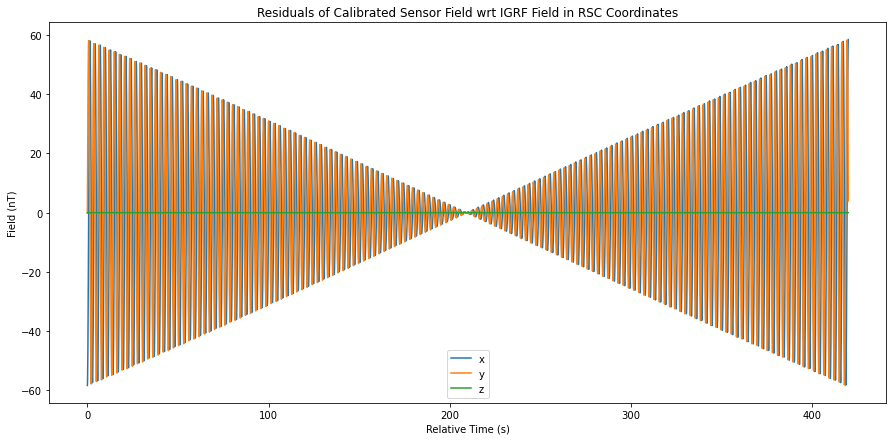

In [90]:
fig, ax = plt.subplots(1, figsize = (15, 7))

ax.plot(ctime, B_IGRF_RSC_x_final-B_cal_RSC_x, label='x')
ax.plot(ctime, B_IGRF_RSC_y_final-B_cal_RSC_y, label='y')
ax.plot(ctime, B_IGRF_RSC_z_final-B_cal_RSC_z, label='z')

ax.set_title('Residuals of Calibrated Sensor Field wrt IGRF Field in RSC Coordinates')
ax.set_xlabel('Relative Time (s)')
ax.set_ylabel('Field (nT)')
#ax.set_xlim(0, 10)
ax.legend()

The residuals did go down to ~60nT! This tells us the importance of having the correct $\omega$ for a good calibration. Next up, let us improve the attitude of the spacecraft.

In [91]:
B_cal_DSC_x = np.cos(phi_final)*B_cal_RSC_x - np.sin(phi_final)*B_cal_RSC_y
B_cal_DSC_y = np.sin(phi_final)*B_cal_RSC_x + np.cos(phi_final)*B_cal_RSC_y
B_cal_DSC_z = B_cal_RSC_z

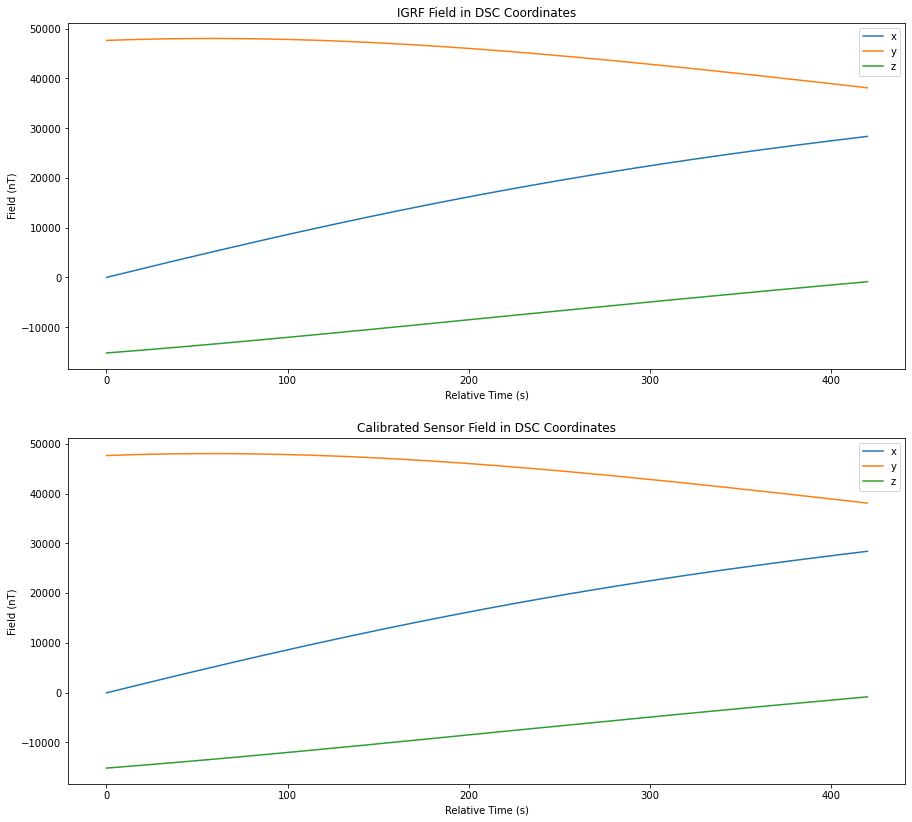

In [92]:
fig, axes = plt.subplots(2, 1, figsize = (15, 14))

axes[0].plot(ctime, B_IGRF_DSC_x, label='x')
axes[0].plot(ctime, B_IGRF_DSC_y, label='y')
axes[0].plot(ctime, B_IGRF_DSC_z, label='z')

axes[0].set_title('IGRF Field in DSC Coordinates')
axes[0].set_xlabel('Relative Time (s)')
axes[0].set_ylabel('Field (nT)')
axes[0].legend()

axes[1].plot(ctime, B_cal_DSC_x, label='x')
axes[1].plot(ctime, B_cal_DSC_y, label='y')
axes[1].plot(ctime, B_cal_DSC_z, label='z')

axes[1].set_title('Calibrated Sensor Field in DSC Coordinates')
axes[1].set_xlabel('Relative Time (s)')
axes[1].set_ylabel('Field (nT)')
axes[1].legend()

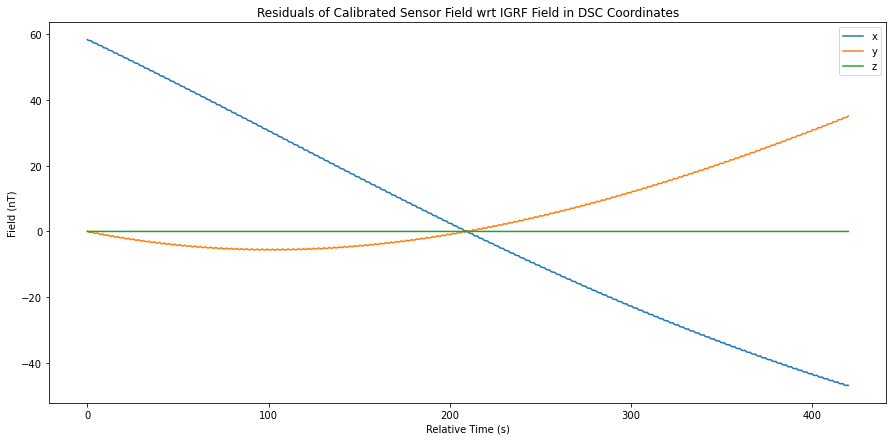

In [93]:
fig, ax = plt.subplots(1, figsize = (15, 7))

ax.plot(ctime, B_IGRF_DSC_x-B_cal_DSC_x, label='x')
ax.plot(ctime, B_IGRF_DSC_y-B_cal_DSC_y, label='y')
ax.plot(ctime, B_IGRF_DSC_z-B_cal_DSC_z, label='z')

ax.set_title('Residuals of Calibrated Sensor Field wrt IGRF Field in DSC Coordinates')
ax.set_xlabel('Relative Time (s)')
ax.set_ylabel('Field (nT)')
#ax.set_xlim(0, 10)
ax.legend()

We will correct the attitude angles $\theta_u, \phi_u$ of the spacecraft by making small angle corrections $\Delta \theta_u, \Delta \phi_u$ that lead to normal equations for deriving the values of these corrections (again, check the derivation separately). Let us go ahead and implement these (rather involved) normal equations. Note that we need to take the gradient of all the terms of the transformation $L^{-1}$ (from GEI to DSC coordinates) with respect to the attitude angles, evaluated at our best guess. Doing so analytically is rather involved, but we can use the definition of a partial derivative and compute these gradients numerically, which is what the function below does.

In [94]:
# Function for computing the matrix of partial derivatives
# These partial derivatives are evaluated at the given attitude angles

def diff_orth_mat(att_angles, b_hat, i, eps = 1e-8):
    
    # First create the matrix taking the fields from GEI to DSC coordinates
    orth_mat_init = np.linalg.inv(orth_mat_create(att_angles, b_hat))
            
    # Create a copy of the attitude angles and then add a small perturbation eps
    # Can try different values of eps to check convergence of derivatives
    att_angles_final = att_angles.copy()
    att_angles_final[i] += eps
            
    # Create the transformation matrix corresponding to the perturbed attitude angles
    orth_mat_final = np.linalg.inv(orth_mat_create(att_angles_final, b_hat))
    
    # Finally, obtain the gradients using the definition of a partial derivative
    orth_mat_diff = (orth_mat_final-orth_mat_init)/eps
    
    return orth_mat_diff

In [95]:
b_u_hat_cal = np.zeros(3*n)

b_u_hat_cal[0:n] = B_cal_DSC_x - B_IGRF_DSC_x
b_u_hat_cal[n:2*n] = B_cal_DSC_y - B_IGRF_DSC_y
b_u_hat_cal[2*n:3*n] = B_cal_DSC_z - B_IGRF_DSC_z

In [96]:
d_theta_u_GEI_2_DSC_init = diff_orth_mat(att_angles_init, b_hat, 0)
d_phi_u_GEI_2_DSC_init = diff_orth_mat(att_angles_init, b_hat, 1)

In [97]:
# Normal equation for correcting attitude angles
A_u_hat_cal = np.zeros((3*n, 2))

A_u_hat_cal[0:n,0] = d_theta_u_GEI_2_DSC_init[0,0]*B_IGRF_GEI_x + d_theta_u_GEI_2_DSC_init[0,1]*B_IGRF_GEI_y + d_theta_u_GEI_2_DSC_init[0,2]*B_IGRF_GEI_z
A_u_hat_cal[0:n,1] = d_phi_u_GEI_2_DSC_init[0,0]*B_IGRF_GEI_x + d_phi_u_GEI_2_DSC_init[0,1]*B_IGRF_GEI_y + d_phi_u_GEI_2_DSC_init[0,2]*B_IGRF_GEI_z

A_u_hat_cal[n:2*n,0] = d_theta_u_GEI_2_DSC_init[1,0]*B_IGRF_GEI_x + d_theta_u_GEI_2_DSC_init[1,1]*B_IGRF_GEI_y + d_theta_u_GEI_2_DSC_init[1,2]*B_IGRF_GEI_z
A_u_hat_cal[n:2*n,1] = d_phi_u_GEI_2_DSC_init[1,0]*B_IGRF_GEI_x + d_phi_u_GEI_2_DSC_init[1,1]*B_IGRF_GEI_y + d_phi_u_GEI_2_DSC_init[1,2]*B_IGRF_GEI_z

A_u_hat_cal[2*n:3*n,0] = d_theta_u_GEI_2_DSC_init[2,0]*B_IGRF_GEI_x + d_theta_u_GEI_2_DSC_init[2,1]*B_IGRF_GEI_y + d_theta_u_GEI_2_DSC_init[2,2]*B_IGRF_GEI_z
A_u_hat_cal[2*n:3*n,1] = d_phi_u_GEI_2_DSC_init[2,0]*B_IGRF_GEI_x + d_phi_u_GEI_2_DSC_init[2,1]*B_IGRF_GEI_y + d_phi_u_GEI_2_DSC_init[2,2]*B_IGRF_GEI_z

A_u_hat_cal = csc_matrix(A_u_hat_cal)

In [98]:
x_u_hat_cal = lsqr(A_u_hat_cal, b_u_hat_cal, atol=1e-10, btol=1e-10)[0]

In [99]:
att_angles_del = np.array([x_u_hat_cal[0], x_u_hat_cal[1]])

In [100]:
att_angles_del

array([-0.00035445,  0.0009365 ])

In [101]:
calc_unit_vec_angles(np.array([np.mean(att_GEI_x), np.mean(att_GEI_y), np.mean(att_GEI_z)])) - att_angles_init

array([-1.e-07,  1.e-05])

You can see that the angle corrections are in the right directions but don't necessarily have the right magnitudes. Sometimes they may not even be in the right direction. This is because the attitude correction is highly sensitive to having the right values for $\omega$ and calibration parameters, which in-turn depend on the attitude ... it's a feedback loop. Nevertheless, the corrections are not so far off so as to throw the algorithm away from a minima, and over subsequent iterations, the hope is for the attitude to improve. By the way, the attitude correction equations have been tested to work correctly if we are purely calibrating for the attitude and nothing else - you can try this yourself by disabling the calibration of any other parameters (just set their value to the true value right after you calibrate for them, you'll see commented lines of code that do this throughout the notebook, feel free to un-comment them to your liking).

In [102]:
att_angles_final = att_angles_init + att_angles_del

In [103]:
u_hat_final = np.array([np.sin(att_angles_final[0])*np.cos(att_angles_final[1]), 
                          np.sin(att_angles_final[0])*np.sin(att_angles_final[1]), 
                          np.cos(att_angles_final[0])])

In [104]:
u_hat_init, u_hat_final

(array([-0.0493015 ,  0.99342992,  0.10327805]),
 array([-0.05022997,  0.99334669,  0.1036306 ]))

In [105]:
DSC_2_GEI_final = orth_mat_create(att_angles_final, b_hat)

In [106]:
GEI_2_DSC_final = np.linalg.inv(DSC_2_GEI_final)

Let us re-calibrate the raw sensor data once again with our new guess of attitude.

In [107]:
B_IGRF_DSC_x_final = GEI_2_DSC_final[0,0]*B_IGRF_GEI_x + GEI_2_DSC_final[0,1]*B_IGRF_GEI_y + GEI_2_DSC_final[0,2]*B_IGRF_GEI_z
B_IGRF_DSC_y_final = GEI_2_DSC_final[1,0]*B_IGRF_GEI_x + GEI_2_DSC_final[1,1]*B_IGRF_GEI_y + GEI_2_DSC_final[1,2]*B_IGRF_GEI_z
B_IGRF_DSC_z_final = GEI_2_DSC_final[2,0]*B_IGRF_GEI_x + GEI_2_DSC_final[2,1]*B_IGRF_GEI_y + GEI_2_DSC_final[2,2]*B_IGRF_GEI_z

In [108]:
B_IGRF_RSC_x_final = np.cos(phi_final)*B_IGRF_DSC_x_final + np.sin(phi_final)*B_IGRF_DSC_y_final
B_IGRF_RSC_y_final = -np.sin(phi_final)*B_IGRF_DSC_x_final + np.cos(phi_final)*B_IGRF_DSC_y_final
B_IGRF_RSC_z_final = B_IGRF_DSC_z_final

In [109]:
B_IGRF_FGM_x_final = RSC_2_FGM[0,0]*B_IGRF_RSC_x_final + RSC_2_FGM[0,1]*B_IGRF_RSC_y_final + RSC_2_FGM[0,2]*B_IGRF_RSC_z_final
B_IGRF_FGM_y_final = RSC_2_FGM[1,0]*B_IGRF_RSC_x_final + RSC_2_FGM[1,1]*B_IGRF_RSC_y_final + RSC_2_FGM[1,2]*B_IGRF_RSC_z_final
B_IGRF_FGM_z_final = RSC_2_FGM[2,0]*B_IGRF_RSC_x_final + RSC_2_FGM[2,1]*B_IGRF_RSC_y_final + RSC_2_FGM[2,2]*B_IGRF_RSC_z_final

In [110]:
A_FGM_cal = np.zeros((3*n, 12))

A_FGM_cal[0:n,0] = B_IGRF_FGM_x_final
A_FGM_cal[0:n,1] = B_IGRF_FGM_y_final
A_FGM_cal[0:n,2] = B_IGRF_FGM_z_final
A_FGM_cal[0:n,3] = np.ones(n)
A_FGM_cal[n:2*n,4] = B_IGRF_FGM_x_final
A_FGM_cal[n:2*n,5] = B_IGRF_FGM_y_final
A_FGM_cal[n:2*n,6] = B_IGRF_FGM_z_final
A_FGM_cal[n:2*n,7] = np.ones(n)
A_FGM_cal[2*n:3*n,8] = B_IGRF_FGM_x_final
A_FGM_cal[2*n:3*n,9] = B_IGRF_FGM_y_final
A_FGM_cal[2*n:3*n,10] = B_IGRF_FGM_z_final
A_FGM_cal[2*n:3*n,11] = np.ones(n)

A_FGM_cal = csc_matrix(A_FGM_cal)

In [111]:
x_FGM_cal = lsqr(A_FGM_cal, b_FGM_cal, atol=1e-10, btol=1e-10)[0]

In [112]:
orth = np.array([[x_FGM_cal[0],x_FGM_cal[1],x_FGM_cal[2]], 
                 [x_FGM_cal[4], x_FGM_cal[5], x_FGM_cal[6]], 
                 [x_FGM_cal[8], x_FGM_cal[9], x_FGM_cal[10]]])

offsets = np.array([x_FGM_cal[3], x_FGM_cal[7], x_FGM_cal[11]])

In [113]:
orth

array([[1.01087819, 0.04896517, 0.04142479],
       [0.01894905, 1.00099099, 0.03132714],
       [0.00465206, 0.00469992, 1.00000203]])

The offsets got way off here, huh. Probably because of the attitude going away from its true value.

In [114]:
offsets

array([ 14.49328824, -16.23524786,  -5.1201714 ])

In [115]:
#orth = np.array([[1.01, 0.05, 0.04], [0.02, 1.0, 0.03], [0.006, 0.006, 1.0]])
#offsets = np.array([100,100,100])

#orth = np.array([[1,0,0],[0,1,0],[0,0,1]])
#offsets = np.array([0,0,0])

In [116]:
calib = np.linalg.inv(orth)

In [117]:
B_cal_FGM_x = calib[0, 0]*(B_raw_FGM_x-offsets[0]) + calib[0, 1]*(B_raw_FGM_y-offsets[1]) + calib[0, 2]*(B_raw_FGM_z-offsets[2])
B_cal_FGM_y = calib[1, 0]*(B_raw_FGM_x-offsets[0]) + calib[1, 1]*(B_raw_FGM_y-offsets[1]) + calib[1, 2]*(B_raw_FGM_z-offsets[2])
B_cal_FGM_z = calib[2, 0]*(B_raw_FGM_x-offsets[0]) + calib[2, 1]*(B_raw_FGM_y-offsets[1]) + calib[2, 2]*(B_raw_FGM_z-offsets[2]) 

In [118]:
B_cal_RSC_x = FGM_2_RSC[0,0]*B_cal_FGM_x + FGM_2_RSC[0,1]*B_cal_FGM_y + FGM_2_RSC[0,2]*B_cal_FGM_z
B_cal_RSC_y = FGM_2_RSC[1,0]*B_cal_FGM_x + FGM_2_RSC[1,1]*B_cal_FGM_y + FGM_2_RSC[1,2]*B_cal_FGM_z
B_cal_RSC_z = FGM_2_RSC[2,0]*B_cal_FGM_x + FGM_2_RSC[2,1]*B_cal_FGM_y + FGM_2_RSC[2,2]*B_cal_FGM_z

In [119]:
B_cal_DSC_x = np.cos(phi_final)*B_cal_RSC_x - np.sin(phi_final)*B_cal_RSC_y
B_cal_DSC_y = np.sin(phi_final)*B_cal_RSC_x + np.cos(phi_final)*B_cal_RSC_y
B_cal_DSC_z = B_cal_RSC_z

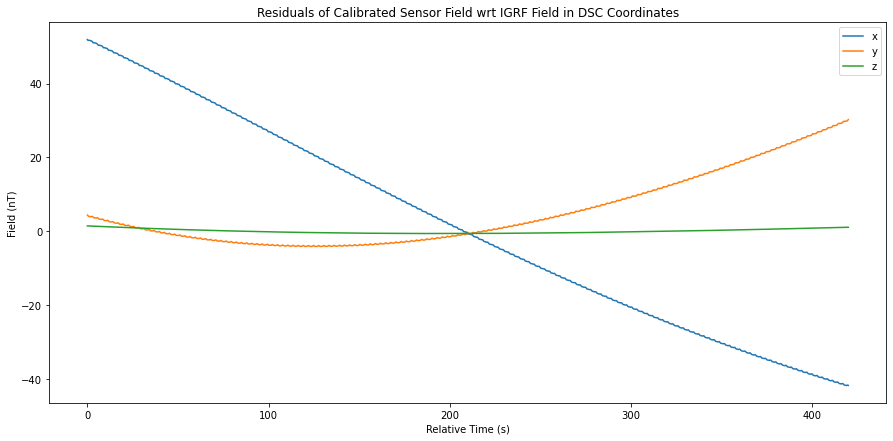

In [120]:
fig, ax = plt.subplots(1, figsize = (15, 7))

ax.plot(ctime, B_IGRF_DSC_x_final-B_cal_DSC_x, label='x')
ax.plot(ctime, B_IGRF_DSC_y_final-B_cal_DSC_y, label='y')
ax.plot(ctime, B_IGRF_DSC_z_final-B_cal_DSC_z, label='z')

ax.set_title('Residuals of Calibrated Sensor Field wrt IGRF Field in DSC Coordinates')
ax.set_xlabel('Relative Time (s)')
ax.set_ylabel('Field (nT)')
#ax.set_xlim(0, 10)
ax.legend()

Even with the attitude being thrown off from the true value slightly, the residuals do decrease. This makes sense because the priority was to reduce the difference between the raw sensor data and the model.

In [121]:
B_IGRF_RSC_x_final = GEI_2_DSC_final[0,0]*B_IGRF_GEI_x + GEI_2_DSC_final[0,1]*B_IGRF_GEI_y + GEI_2_DSC_final[0,2]*B_IGRF_GEI_z
B_IGRF_RSC_y_final = GEI_2_DSC_final[1,0]*B_IGRF_GEI_x + GEI_2_DSC_final[1,1]*B_IGRF_GEI_y + GEI_2_DSC_final[1,2]*B_IGRF_GEI_z
B_IGRF_RSC_z_final = GEI_2_DSC_final[2,0]*B_IGRF_GEI_x + GEI_2_DSC_final[2,1]*B_IGRF_GEI_y + GEI_2_DSC_final[2,2]*B_IGRF_GEI_z

In [122]:
DSC_2_GEI_final = np.linalg.inv(GEI_2_DSC_final)

In [123]:
B_cal_GEI_x = DSC_2_GEI_final[0,0]*B_cal_DSC_x + DSC_2_GEI_final[0,1]*B_cal_DSC_y + DSC_2_GEI_final[0,2]*B_cal_DSC_z
B_cal_GEI_y = DSC_2_GEI_final[1,0]*B_cal_DSC_x + DSC_2_GEI_final[1,1]*B_cal_DSC_y + DSC_2_GEI_final[1,2]*B_cal_DSC_z
B_cal_GEI_z = DSC_2_GEI_final[2,0]*B_cal_DSC_x + DSC_2_GEI_final[2,1]*B_cal_DSC_y + DSC_2_GEI_final[2,2]*B_cal_DSC_z

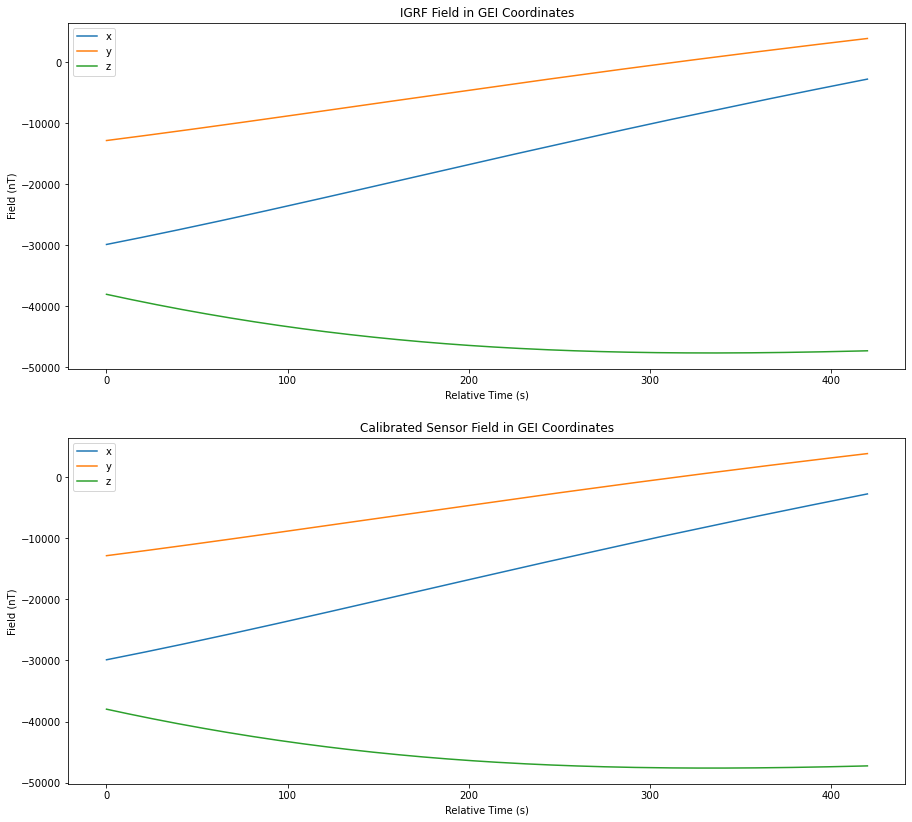

In [124]:
fig, axes = plt.subplots(2, 1, figsize = (15, 14))

axes[0].plot(ctime, B_IGRF_GEI_x, label='x')
axes[0].plot(ctime, B_IGRF_GEI_y, label='y')
axes[0].plot(ctime, B_IGRF_GEI_z, label='z')

axes[0].set_title('IGRF Field in GEI Coordinates')
axes[0].set_xlabel('Relative Time (s)')
axes[0].set_ylabel('Field (nT)')
#axes[0].set_xlim(0, 10)
axes[0].legend()

axes[1].plot(ctime, B_cal_GEI_x, label='x')
axes[1].plot(ctime, B_cal_GEI_y, label='y')
axes[1].plot(ctime, B_cal_GEI_z, label='z')

axes[1].set_title('Calibrated Sensor Field in GEI Coordinates')
axes[1].set_xlabel('Relative Time (s)')
axes[1].set_ylabel('Field (nT)')
#axes[1].set_xlim(0, 10)
axes[1].legend()

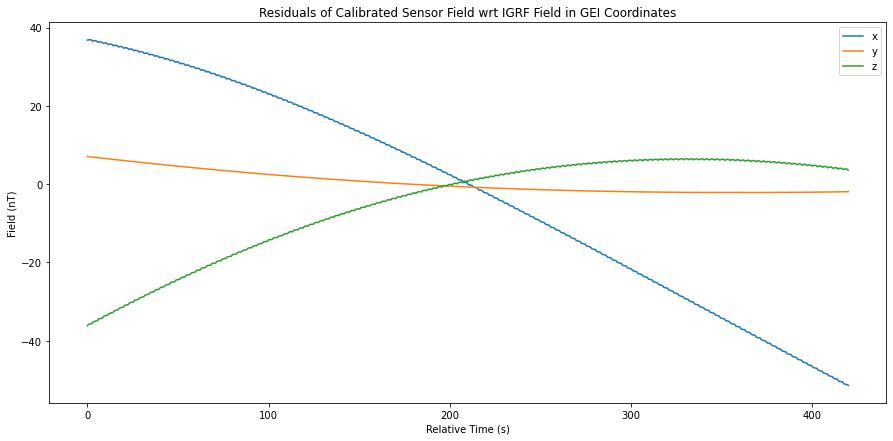

In [125]:
fig, ax = plt.subplots(1, figsize = (15, 7))

ax.plot(ctime, B_IGRF_GEI_x-B_cal_GEI_x, label='x')
ax.plot(ctime, B_IGRF_GEI_y-B_cal_GEI_y, label='y')
ax.plot(ctime, B_IGRF_GEI_z-B_cal_GEI_z, label='z')

ax.set_title('Residuals of Calibrated Sensor Field wrt IGRF Field in GEI Coordinates')
ax.set_xlabel('Relative Time (s)')
ax.set_ylabel('Field (nT)')
#ax.set_xlim(0, 10)
ax.legend()

In [126]:
print(u_hat_init, 2*np.pi/w_init, phi0_init)

[-0.0493015   0.99342992  0.10327805] 2.84001 3.1356701928312027


In [127]:
print(u_hat_final, 2*np.pi/w_final, phi0_final)

[-0.05022997  0.99334669  0.1036306 ] 2.840007511335622 3.1408106872760206


And that ends our calibration process! Let us see how this fares if we run it on a loop, check <code>6-const_w_calibrate_re.ipynb</code>.